Till now we have a used a mix of `Future_Return_5d` and the `Close` price in our models. To address this, before we go on with out deep learning models let's perform a small comparitive analysis over the two specific features to see what we can unearth.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the datasets
nvidia_data = pd.read_csv("../data/nvidia_stock_features_selected.csv", parse_dates=["Date"], index_col="Date")
apple_data = pd.read_csv("../data/apple_stock_features_selected.csv", parse_dates=["Date"], index_col="Date")
microsoft_data = pd.read_csv("../data/microsoft_stock_features_selected.csv", parse_dates=["Date"], index_col="Date")

# Standardizing column names for consistency
future_return_col = 'Future_Return_5d'

In [3]:
# Function for Exploratory Analysis
def analyze_stock(stock_data, stock_name):
    print(f"Analyzing {stock_name}")

    # Plot Close Price vs Future Return 5d
    plt.figure(figsize=(15,6))
    plt.subplot(2,1,1)
    plt.plot(stock_data.index, stock_data['Close'], label=f"{stock_name} Close", color='blue')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(stock_data.index, stock_data[future_return_col], label=f"{stock_name} Future Return 5D", color='red')
    plt.legend()
    plt.suptitle(f"{stock_name} - Close Price vs Future Return 5D")
    plt.show()

    # ADF Test for Stationarity
    adf_close = adfuller(stock_data["Close"].dropna())
    adf_future_return = adfuller(stock_data[future_return_col].dropna())

    print(f"ADF Test Results - {stock_name}")
    print(f"Close Price: ADF Statistic = {adf_close[0]:.4f}, p-value = {adf_close[1]:.6f}")
    print(f"Future Return 5D: ADF Statistic = {adf_future_return[0]:.4f}, p-value = {adf_future_return[1]:.6f}")

    # Autocorrelation Plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    plot_acf(stock_data["Close"].dropna(), ax=axes[0, 0])
    axes[0, 0].set_title(f"ACF - {stock_name} Close Price")
    plot_pacf(stock_data["Close"].dropna(), ax=axes[0, 1])
    axes[0, 1].set_title(f"PACF - {stock_name} Close Price")

    plot_acf(stock_data[future_return_col].dropna(), ax=axes[1, 0])
    axes[1, 0].set_title(f"ACF - {stock_name} Future Return 5D")
    plot_pacf(stock_data[future_return_col].dropna(), ax=axes[1, 1])
    axes[1, 1].set_title(f"PACF - {stock_name} Future Return 5D")

    plt.tight_layout()
    plt.show()

    # Correlation Heatmap
    corr_matrix = stock_data.corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Correlation Matrix - {stock_name}")
    plt.show()

    # Feature Importance using Random Forest
    features = stock_data.drop(columns=[future_return_col, "Close"]).dropna()
    target_close = stock_data["Close"].dropna().reindex(features.index)
    target_future_return = stock_data[future_return_col].dropna().reindex(features.index)

    X_train, X_test, y_train_close, y_test_close = train_test_split(features, target_close, test_size=0.2, random_state=42)
    X_train, X_test, y_train_future, y_test_future = train_test_split(features, target_future_return, test_size=0.2, random_state=42)

    rf_model_close = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_future = RandomForestRegressor(n_estimators=100, random_state=42)

    rf_model_close.fit(X_train, y_train_close)
    rf_model_future.fit(X_train, y_train_future)

    y_pred_close = rf_model_close.predict(X_test)
    y_pred_future = rf_model_future.predict(X_test)

    mse_close = mean_squared_error(y_test_close, y_pred_close)
    r2_close = r2_score(y_test_close, y_pred_close)

    mse_future = mean_squared_error(y_test_future, y_pred_future)
    r2_future = r2_score(y_test_future, y_pred_future)

    feature_importances_close = rf_model_close.feature_importances_
    feature_importances_future = rf_model_future.feature_importances_

    feature_importance_df = pd.DataFrame({
        "Feature": features.columns,
        "Importance (Close)": feature_importances_close,
        "Importance (Future Return 5D)": feature_importances_future
    }).sort_values(by="Importance (Future Return 5D)", ascending=False)

    print(f"Feature Importance - {stock_name}")
    print(feature_importance_df)

    # Print Model Performance
    print(f"\nModel Performance - {stock_name}")
    print(f"Close Price: MSE = {mse_close:.4f}, R² = {r2_close:.4f}")
    print(f"Future Return 5D: MSE = {mse_future:.4f}, R² = {r2_future:.4f}")
    print("-" * 50)

    return {
        "Stock": stock_name,
        "ADF Close": adf_close[:2],
        "ADF Future Return 5D": adf_future_return[:2],
        "MSE Close": mse_close,
        "R2 Close": r2_close,
        "MSE Future Return 5D": mse_future,
        "R2 Future Return 5D": r2_future
    }


Analyzing NVIDIA


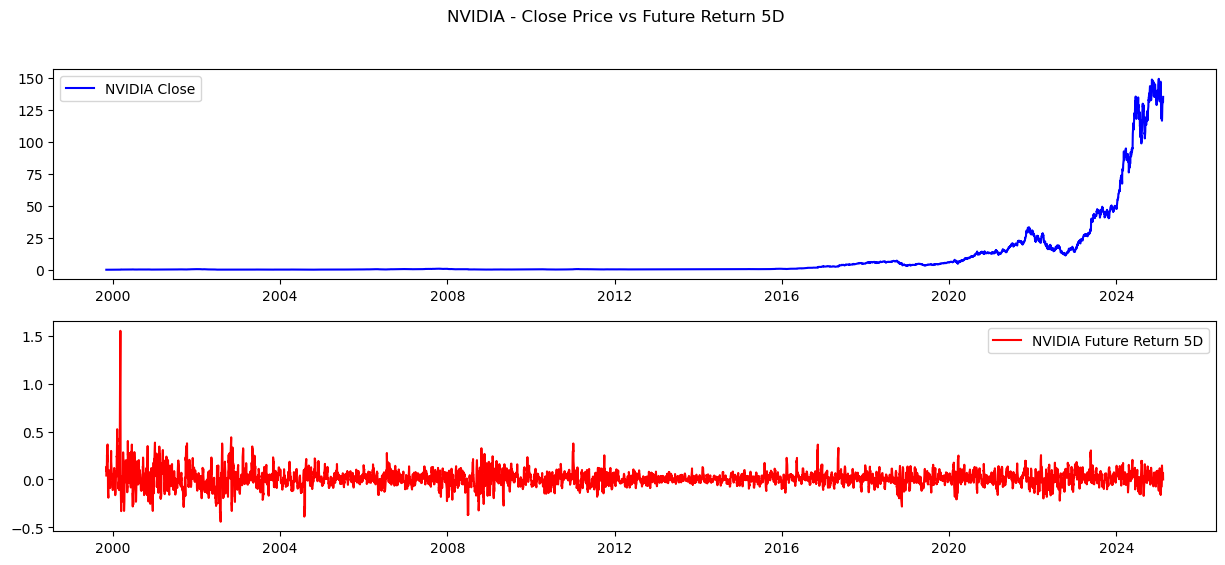

ADF Test Results - NVIDIA
Close Price: ADF Statistic = 4.0238, p-value = 1.000000
Future Return 5D: ADF Statistic = -13.3433, p-value = 0.000000


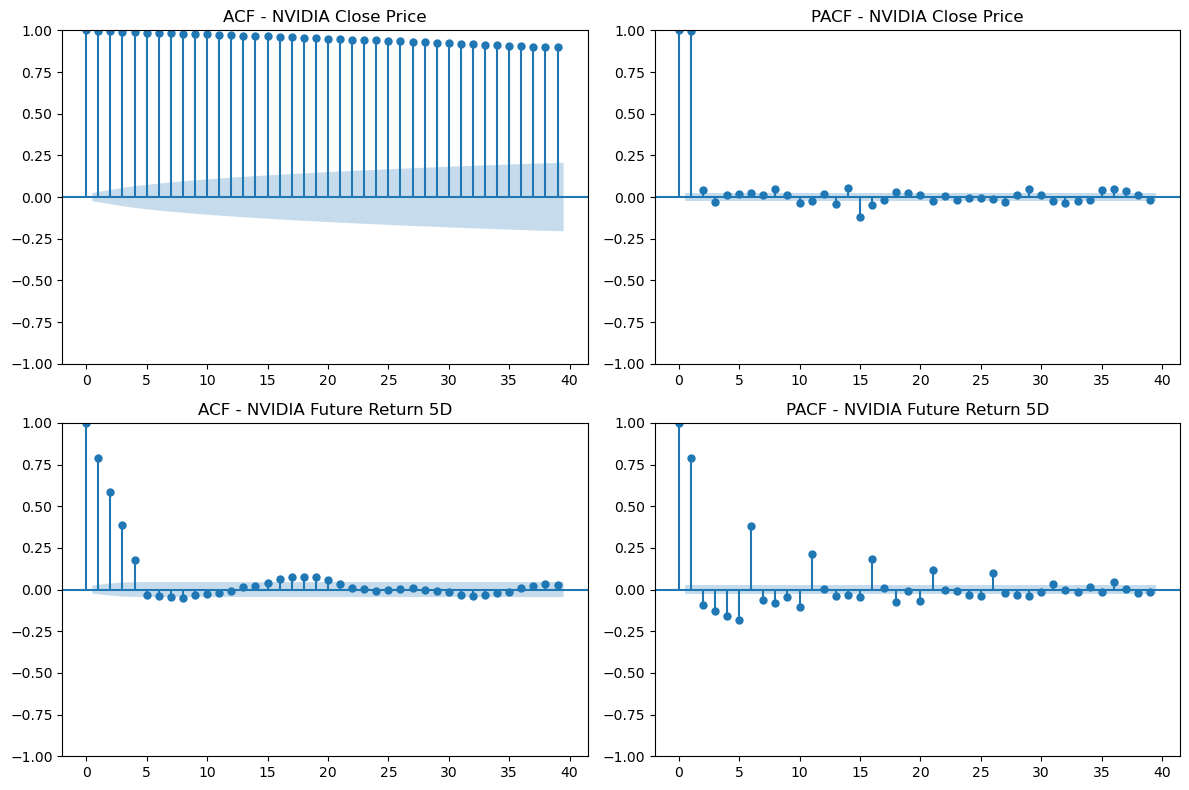

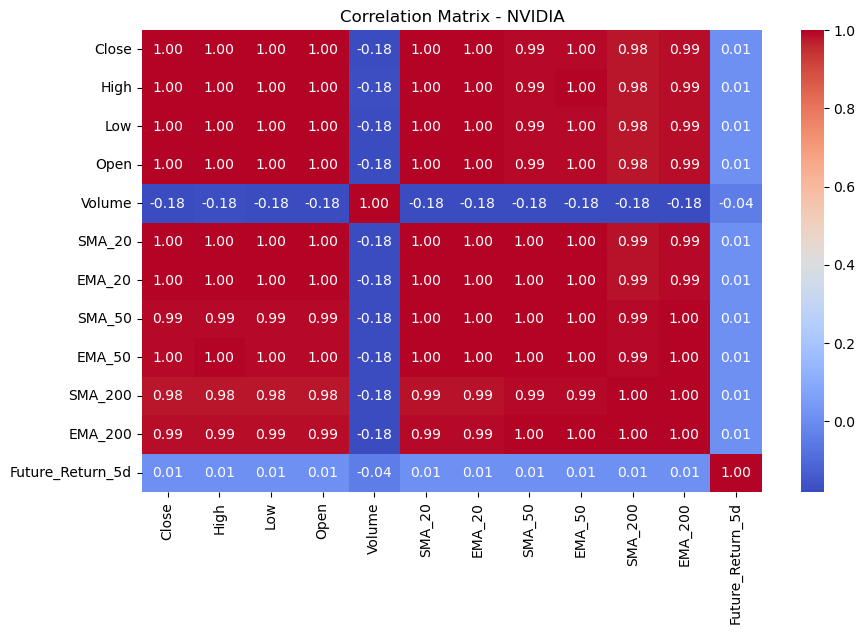

Feature Importance - NVIDIA
   Feature  Importance (Close)  Importance (Future Return 5D)
8  SMA_200            0.081758                       0.154549
9  EMA_200            0.097946                       0.128942
5   EMA_20            0.106849                       0.106455
6   SMA_50            0.106106                       0.101893
4   SMA_20            0.106106                       0.097961
7   EMA_50            0.073874                       0.096580
3   Volume            0.000013                       0.088356
0     High            0.223506                       0.088067
1      Low            0.142629                       0.076703
2     Open            0.061213                       0.060495

Model Performance - NVIDIA
Close Price: MSE = 0.3392, R² = 0.9995
Future Return 5D: MSE = 0.0027, R² = 0.6265
--------------------------------------------------


In [4]:
# Run Analysis for NVIDIA
nvidia_results = analyze_stock(nvidia_data, "NVIDIA")

Analyzing Apple


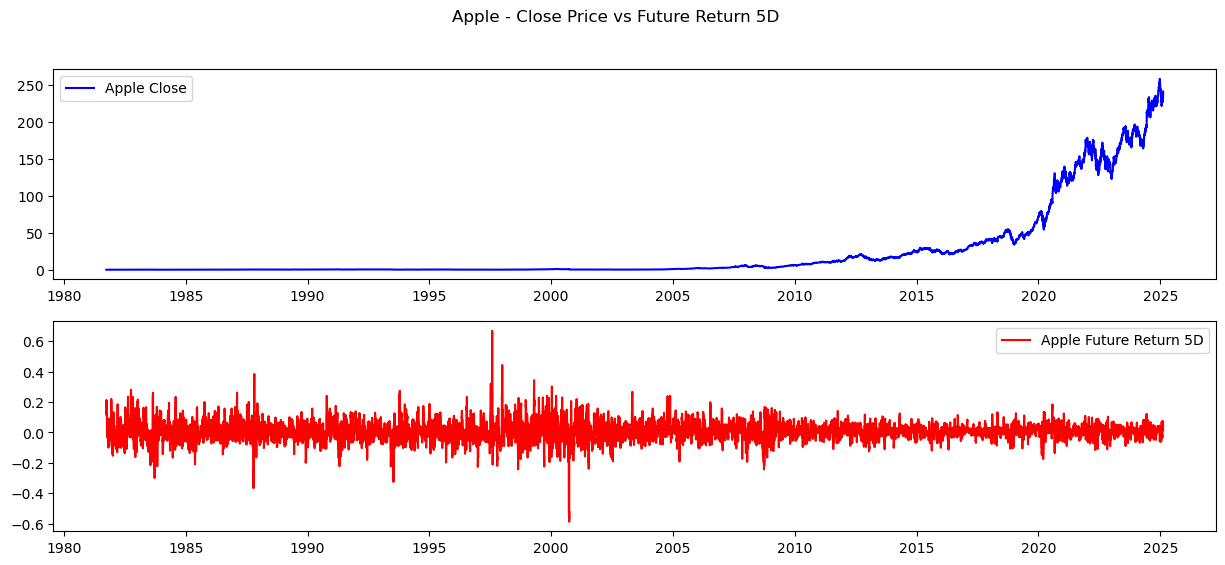

ADF Test Results - Apple
Close Price: ADF Statistic = 4.5449, p-value = 1.000000
Future Return 5D: ADF Statistic = -15.7479, p-value = 0.000000


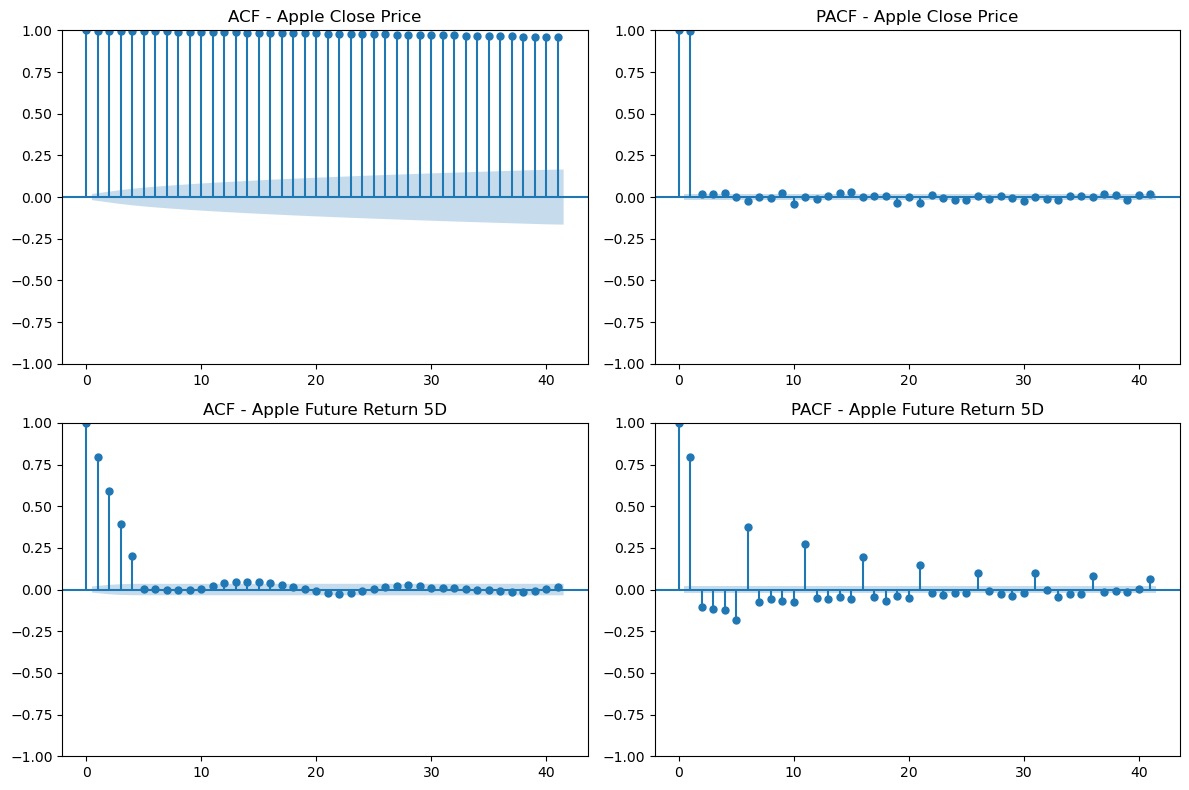

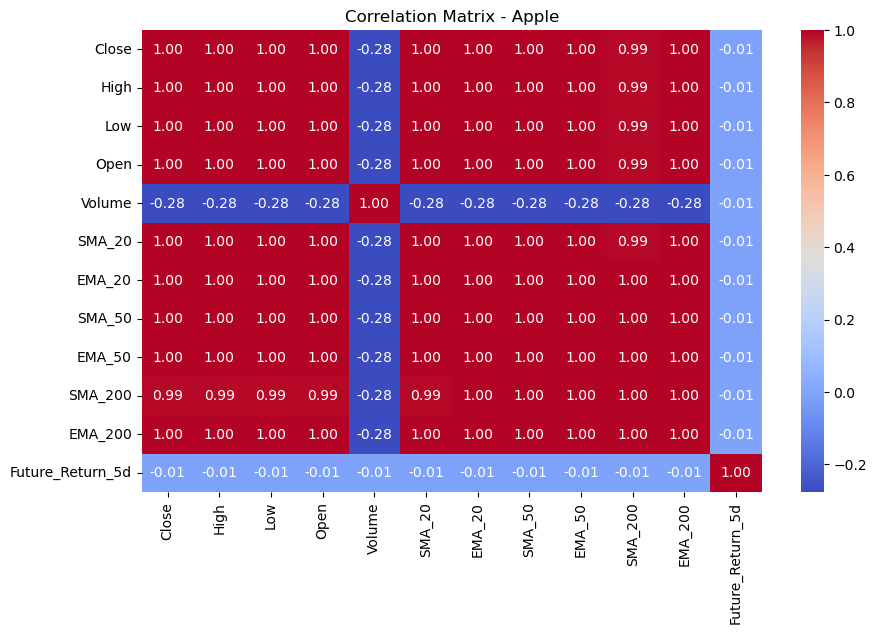

Feature Importance - Apple
   Feature  Importance (Close)  Importance (Future Return 5D)
8  SMA_200            0.087517                       0.152680
9  EMA_200            0.098855                       0.149189
6   SMA_50            0.035645                       0.117013
3   Volume            0.000007                       0.093099
4   SMA_20            0.149556                       0.091159
7   EMA_50            0.079176                       0.090547
1      Low            0.143249                       0.082293
5   EMA_20            0.142389                       0.079839
0     High            0.183999                       0.075507
2     Open            0.079607                       0.068675

Model Performance - Apple
Close Price: MSE = 0.2734, R² = 0.9999
Future Return 5D: MSE = 0.0016, R² = 0.5758
--------------------------------------------------


In [5]:
# Run Analysis for Apple
apple_results = analyze_stock(apple_data, "Apple")

Analyzing Microsoft


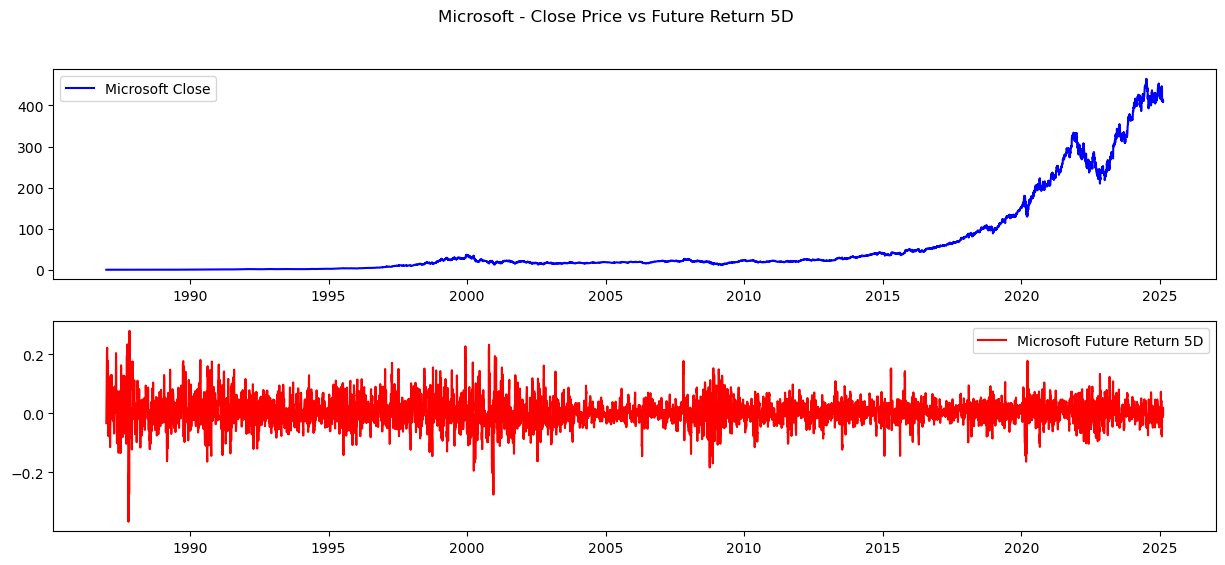

ADF Test Results - Microsoft
Close Price: ADF Statistic = 4.0251, p-value = 1.000000
Future Return 5D: ADF Statistic = -16.9062, p-value = 0.000000


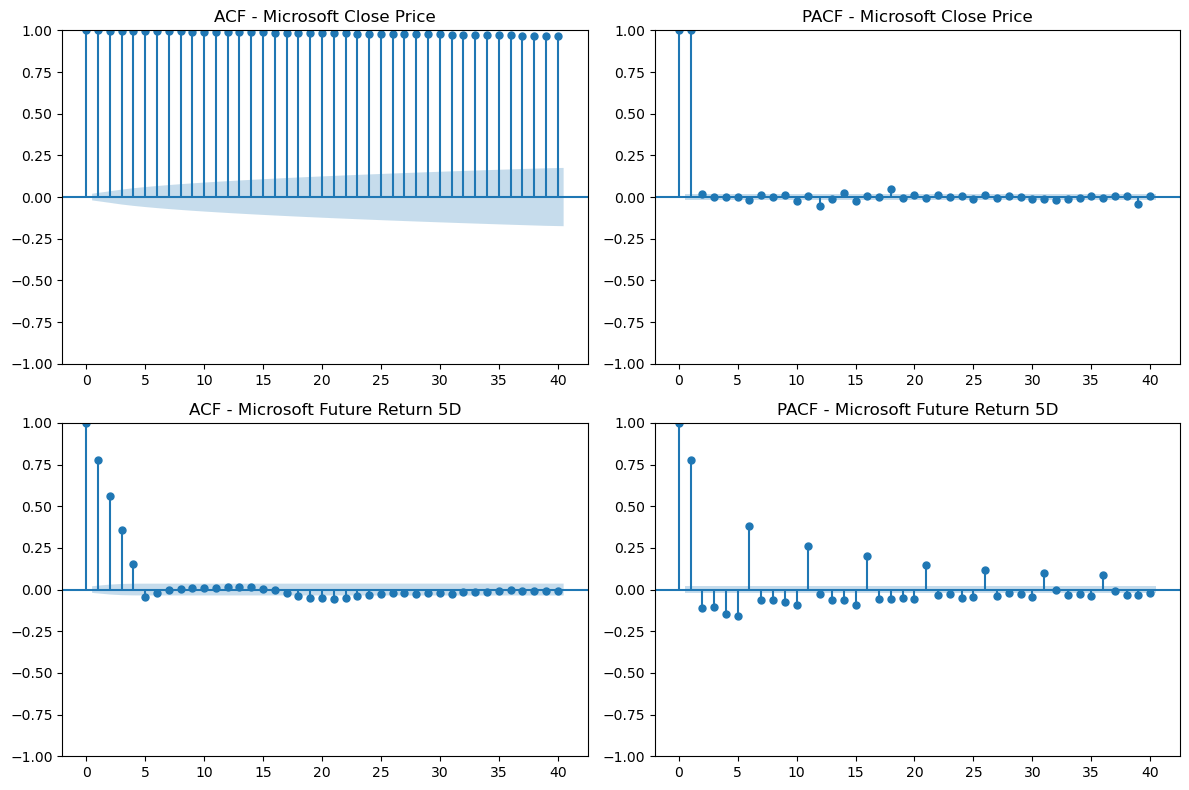

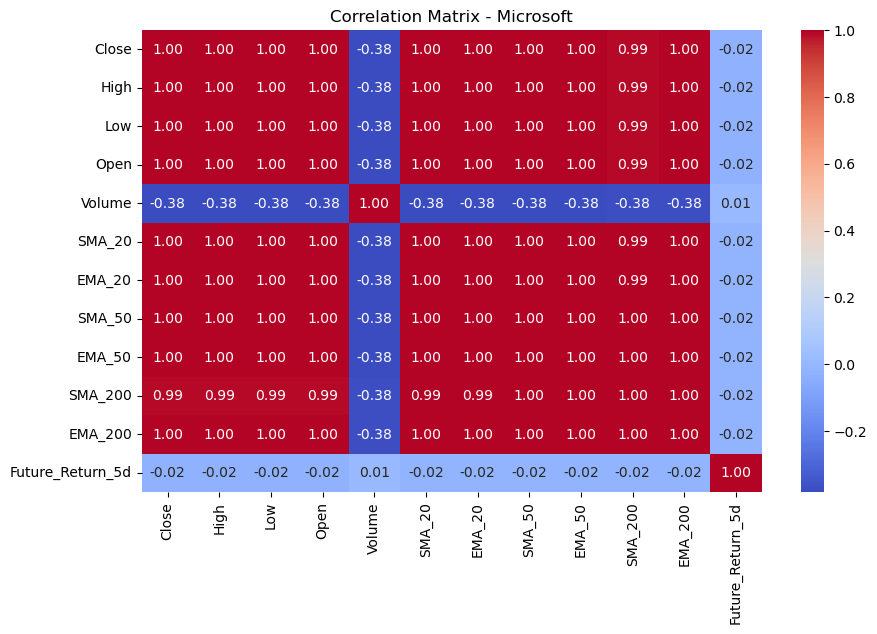

Feature Importance - Microsoft
   Feature  Importance (Close)  Importance (Future Return 5D)
8  SMA_200            0.002308                       0.144869
9  EMA_200            0.005288                       0.129879
6   SMA_50            0.003123                       0.101504
3   Volume            0.000006                       0.101335
4   SMA_20            0.002254                       0.100083
1      Low            0.288026                       0.097295
7   EMA_50            0.002858                       0.092552
0     High            0.632971                       0.089026
5   EMA_20            0.003480                       0.077446
2     Open            0.059686                       0.066011

Model Performance - Microsoft
Close Price: MSE = 0.8511, R² = 0.9999
Future Return 5D: MSE = 0.0009, R² = 0.5166
--------------------------------------------------


In [6]:
# Run Analysis for Microsoft
microsoft_results = analyze_stock(microsoft_data, "Microsoft")

In [7]:
# Consolidate Results
results_df = pd.DataFrame([nvidia_results, apple_results, microsoft_results])
print("\nFinal Summary")
results_df


Final Summary


,Stock,ADF Close,ADF Future Return 5D,MSE Close,R2 Close,MSE Future Return 5D,R2 Future Return 5D
0,NVIDIA,"(4.023772415113981, 1.0)","(-13.343289296892559, 5.861919546936647e-25)",0.339207,0.999458,0.002710,0.626528
1,Apple,"(4.544907526840628, 1.0)","(-15.747932822376768, 1.2332541145763302e-28)",0.273446,0.999901,0.001558,0.575781
2,Microsoft,"(4.025088328844739, 1.0)","(-16.90615728945537, 1.0188979492325099e-29)",0.851056,0.999920,0.000863,0.516575


1. Stationarity (ADF Test)
- Close Price: Non-stationary for all three stocks (ADF values > 4, p-value = 1.0).
- Future Return 5D: Stationary for all stocks (ADF values < -13, p-value ≈ 0).

2. Close Price (R squareed ~ 1)
- Almost all close price have values almost equal to 1 meaning Close Price is an easier choice to predict if we are only looking for model accuracy.
- Future return has an R squared range between 0.52 and 0.63 meaning its more volatile basically making it more robust and challenging to predict.

In the next few models we will further test these assumptions and see which model does better.